<a href="https://colab.research.google.com/github/RaiShra1/Computer-Vision-and-Image-Processing/blob/main/2D_Image_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from scipy import signal
from scipy.spatial import distance
import math

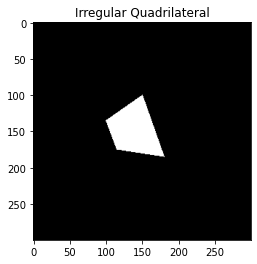

In [31]:
# Create new Image of size 300x300
img = Image.new('L', (300,300), 0)

draw = ImageDraw.Draw(img)

draw.polygon([(100,135),(150, 100), (180, 185), (115, 175)], outline=1, fill =1)

plt.imshow(img, cmap='gray')
plt.title("Irregular Quadrilateral")
plt.show()

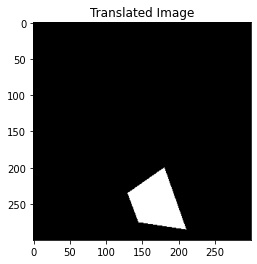

In [32]:
# translate the image by 30,100

translation_Matrix =np.float32([[1, 0, 30], [0, 1, 100]])

translated_img = cv2.warpAffine(np.array(img), translation_Matrix, (300,300))

plt.imshow(translated_img, cmap='gray')
plt.title("Translated Image")
plt.show()


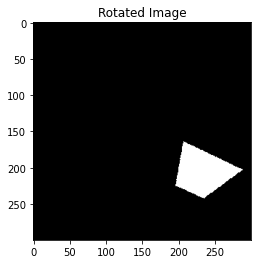

In [33]:
#rotate the image by 45 degrees
rotation_matrix = cv2.getRotationMatrix2D((150,150), 45, 1)
rotated_img= cv2.warpAffine(translated_img,rotation_matrix,(300,300))

plt.imshow(rotated_img, cmap='gray')
plt.title("Rotated Image")
plt.show()

In [35]:
# Define function to find angles of corners using Euclidean distances
def getAngles(points):
    # Find Euclidean distances between all points
    euclidean_dist = distance.cdist(points, points, 'euclidean')
    print('Euclidean Distances between Corner Points', euclidean_dist)
    #Init  
    angles = np.empty((0,1), dtype='float32')
    # For current corner
    for i in range(points.shape[0]):
        # Reset max angle
        angle = 0
        # Find index in Euclidean matrix for all other corners
        corners = np.nonzero(euclidean_dist[i,:])
        
        # For combinations of 2 other corner points
        for j in range(points.shape[0]-1):
            # Order for other 2 point combinations - [1,2], [1,3], [2,3]
            if j == points.shape[0] - 2:
                k = 1
                m = j
            else:
                k = 0
                m = j+1
            
            # Find line 1 between current corner and other corner 1 
            l1 = euclidean_dist[i,corners[0][k]]
            # Find line 2 between current corner and other corner 2 
            l2 = euclidean_dist[i,corners[0][m]]
            # Find line 3 between other corner 1 and other corner 2 
            l3 = euclidean_dist[corners[0][k], corners[0][m]]
            # Use Law of Cosines to find angle of current corner
            tmp_angle = np.arccos((l3**2 - l1**2 - l2**2) / (-2 * l1 * l2))
            
            # Use largest angle for current corner from combinations of other corners 
            if tmp_angle > angle:
                angle = tmp_angle
                
            print(i, j, 'Corners:', corners)
            print('Point1', corners[0][k], 'Point2', corners[0][m],
                  'Dist 1:', l1, 'Dist2:', l2, 'Angle:', tmp_angle)
    
        # Add final angle for current corner to final angle array
        angles = np.concatenate((angles,[[angle]]), axis=0)
    return angles

In [9]:
def getCornerCoordinates(img):
    # Initialize Matrix for max values at each corner to assign single point
    corners = np.empty((0,2), dtype = 'uint16')
    # For each corner:
    for i in range(4):
        # Find the max pixel value coordinate in the entire image
        max_ind = np.unravel_index(np.argmax(img, axis=None), img.shape)
        # Store coordinate in corners matrix
        corners = np.concatenate((corners, [[max_ind[0], max_ind[1]]]), axis=0)
        # Assign intensities for that cluster (pixels around current max) to 0 
        img[max_ind[0]-5:max_ind[0]+5, max_ind[1]-5:max_ind[1]+5] = 0
        # Repeat for new max pixel intensity coordinate
    return corners

In [40]:
# Function to find detect corners and assign descriptors to each point
def cornerDetector(img, threshold):

    h = img.shape[0]
    w = img.shape[1]
    # Determine convolution kernels for x and y direction
    kern_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kern_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # Convolve to get x and y image gradients
    I_x = signal.convolve2d(img, kern_x, mode='same')
    I_y = signal.convolve2d(img, kern_y, mode='same')
    
    # Calculate Ix^2, Iy^2, and Ixy
    I_xx = I_x**2
    I_yy = I_y**2
    I_xy = I_x * I_y
    
    k = 0.05
    # If section size = 3x3, offset = 3/2 = 1
    offset = 1
    # Initialize matrix for response at each coordinate
    h_r = np.empty((0,3), dtype='uint16')
    
    for y in range(offset, h - offset):
        for x in range(offset, w - offset):
            # Find sum of Ix^2, Iy^2, and Ixy at each sectionin each image 
            S_xx = np.sum(I_xx[y - offset:y + 1 + offset,\
                               x - offset:x + 1 + offset])
            S_yy = np.sum(I_yy[y - offset:y + 1 + offset,\
                               x - offset:x + 1 + offset])
            S_xy = np.sum(I_xy[y - offset:y + 1 + offset,\
                               x - offset:x + 1 + offset])
            
            # determinant
            det = (S_xx * S_yy) - (S_xy**2)
            # Trace
            trace = S_xx + S_yy
            # Response
            r = det - k * (trace**2)
            # Combine with current image coordinate
            resp = [[x, y, r]]
            # Add to response matrix
            h_r = np.concatenate((h_r, resp), axis=0)
              
    #Initialize matrix to view corners
    img_copy = np.zeros((h,w))
    img_corners = np.zeros((h,w))
    
    # For response in response matrix
    for i in range(h_r.shape[0]):
        x, y, r = h_r[i,0].astype('uint16'), h_r[i,1].astype('uint16'), h_r[i,2]
        # If response is larger than threshold, it is probably a corner
        if r > threshold:
            img_corners[y,x] = 1
            img_copy[y,x] = r / np.amax(h_r[:,2])

    
    # Find single coordinate for each corner
    corners = getCornerCoordinates(img_copy)
    # Find angles for each corner    
    angles = getAngles(corners)

    # print(corners, angles)
    # print(angles)
        
    # Add angle to each image corner coordinate
    corner_descript = np.concatenate((corners, angles), axis=1)
    print('Corner Points and Angle Descriptor')
    print(corner_descript)
    
    #     # Plot Gradients, Image, and Corners
    #     plot([I_x, I_y, I_xx, I_yy, img, img_corners],\
    #          cmap='gray', subplot_size=(3,2), figsize=(20,20),
    #          title=['Image Gradient Ix',
    #                 'Image Gradient Iy',
    #                 'Image Gradient Ixx',
    #                 'Image Gradient Iyy',
    #                 'Image',
    #                 'Image Corners'])
    # Plot original, translated and rotated images
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(img, cmap ='gray')
    plt.title("Image")
    plt.subplot(1,2,2)
    plt.imshow(img_corners, cmap ='gray')
    plt.title('Image Corners')
          
        
    return corner_descript

In [37]:
#Match Corners found
def matchFeatures(corners1, corners2):
    # Initialize location arrays for sorted image 1 and 2 matches
    loc1 = np.zeros((corners1.shape[0], 2))
    loc2 = np.zeros((corners1.shape[0], 2))
    # For each corner in image 1
    for i in range(corners1.shape[0]):
        # Initialize high initial angle error
        angle_error = 10
        # Compare to each corner in image 2
        for j in range(corners2.shape[0]):
            # Find error between descriptors (angle) of the two features
            tmp_error = np.abs(corners1[i,2] - corners2[j,2])
            # If error is less than previous error
            if tmp_error < angle_error:
                # Current coordinates match 
                angle_error = tmp_error
                # Assign current corner coordinates for image 1
                loc1[i,:] = corners1[i, 0:2]
                # Assign current corner coordinates for image 2
                loc2[i,:] = corners2[j, 0:2]

        print('Corner Location Matches Check:')
        for j in range(loc1.shape[0]): print(loc1[j,:], loc2[j,:])
    return loc1, loc2

In [38]:
def drawMatches(img1, img2, matches, inliers = None):
    # Create a new output image that concatenates the two images together
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]
    img1 = img1.astype('uint8') * 255
    img2 = img2.astype('uint8') * 255
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')

    # Place the first image to the left
    out[:rows1,:cols1,:] = np.dstack([img1, img1, img1])

    # Place the next image to the right of it
    out[:rows2,cols1:cols1+cols2,:] = np.dstack([img2, img2, img2])

    # draw circles, then connect a line between them
    for i in range(matches.shape[0]):
        
        (y1,x1) = matches[i,0:2]
        (y2,x2) = matches[i,2:4]
        
        # Draw circle at both co-ordinates
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)

        # Draw line between the two points
        if inliers is not None and inlier:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)),\
                     (0, 255, 0), 1)
        elif inliers is not None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)),\
                     (0, 0, 255), 1)

        if inliers is None:
            cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)),\
                     (255, 0, 0), 1)

    return out

Euclidean Distances between Corner Points [[ 0.         87.92041856 60.46486583 81.85963596]
 [87.92041856  0.         92.96235797 64.62971453]
 [60.46486583 92.96235797  0.         42.72001873]
 [81.85963596 64.62971453 42.72001873  0.        ]]
0 0 Corners: (array([1, 2, 3]),)
Point1 1 Point2 2 Dist 1: 87.92041856133307 Dist2: 60.4648658313239 Angle: 1.309757719487787
0 1 Corners: (array([1, 2, 3]),)
Point1 1 Point2 3 Dist 1: 87.92041856133307 Dist2: 81.85963596303125 Angle: 0.7779312163030114
0 2 Corners: (array([1, 2, 3]),)
Point1 2 Point2 3 Dist 1: 60.4648658313239 Dist2: 81.85963596303125 Angle: 0.5318265031847753
1 0 Corners: (array([0, 2, 3]),)
Point1 0 Point2 2 Dist 1: 87.92041856133307 Dist2: 92.9623579735368 Angle: 0.6794796998887241
1 1 Corners: (array([0, 2, 3]),)
Point1 0 Point2 3 Dist 1: 87.92041856133307 Dist2: 64.6297145282261 Angle: 1.094949401720165
1 2 Corners: (array([0, 2, 3]),)
Point1 2 Point2 3 Dist 1: 92.9623579735368 Dist2: 64.6297145282261 Angle: 0.4154697018

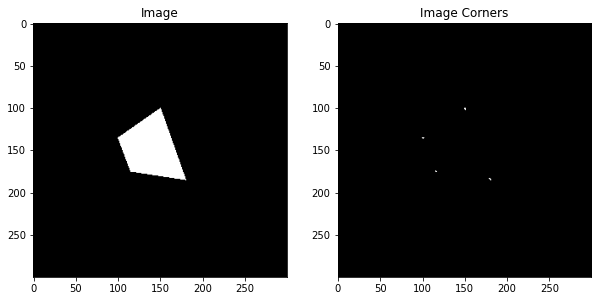

In [41]:
corners_original = cornerDetector(np.array(img), 600)

Euclidean Distances between Corner Points [[ 0.         88.5663593  93.62157871 65.        ]
 [88.5663593   0.         61.         81.93289938]
 [93.62157871 61.          0.         42.54409477]
 [65.         81.93289938 42.54409477  0.        ]]
0 0 Corners: (array([1, 2, 3]),)
Point1 1 Point2 2 Dist 1: 88.56635930193812 Dist2: 93.62157870918435 Angle: 0.6806551353033823
0 1 Corners: (array([1, 2, 3]),)
Point1 1 Point2 3 Dist 1: 88.56635930193812 Dist2: 65.0 Angle: 1.0869494452130226
0 2 Corners: (array([1, 2, 3]),)
Point1 2 Point2 3 Dist 1: 93.62157870918435 Dist2: 65.0 Angle: 0.4062943099096404
1 0 Corners: (array([0, 2, 3]),)
Point1 0 Point2 2 Dist 1: 88.56635930193812 Dist2: 61.0 Angle: 1.3086677647766487
1 1 Corners: (array([0, 2, 3]),)
Point1 0 Point2 3 Dist 1: 88.56635930193812 Dist2: 81.93289937503738 Angle: 0.7785769867912514
1 2 Corners: (array([0, 2, 3]),)
Point1 2 Point2 3 Dist 1: 61.0 Dist2: 81.93289937503738 Angle: 0.5300907779853972
2 0 Corners: (array([0, 1, 3]),)
Poin

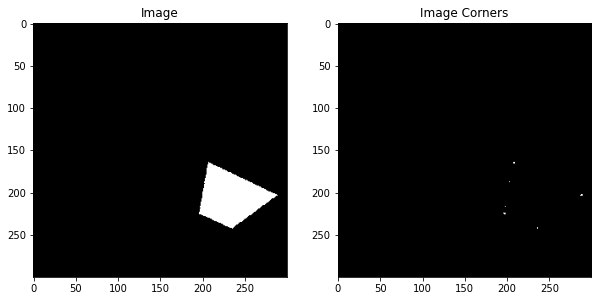

In [42]:
corners_rotated = cornerDetector(np.array(rotated_img), 600)

Corner Location Matches Check:
[101. 150.] [165. 207.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
Corner Location Matches Check:
[101. 150.] [165. 207.]
[184. 179.] [203. 287.]
[0. 0.] [0. 0.]
[0. 0.] [0. 0.]
Corner Location Matches Check:
[101. 150.] [165. 207.]
[184. 179.] [203. 287.]
[135. 100.] [225. 196.]
[0. 0.] [0. 0.]
Corner Location Matches Check:
[101. 150.] [165. 207.]
[184. 179.] [203. 287.]
[135. 100.] [225. 196.]
[175. 115.] [242. 235.]


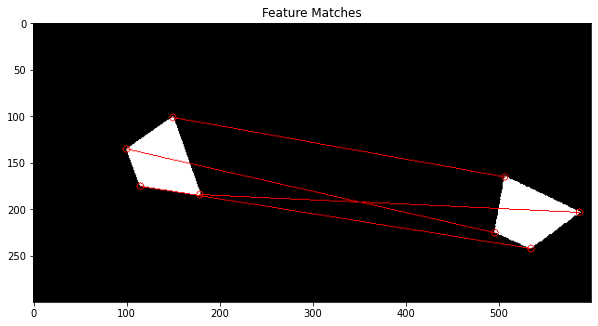

In [54]:
#match features
matches1, matches2 = matchFeatures(corners_original,corners_rotated)
matches = np.concatenate((matches1,matches2), axis =1)

matched_img = drawMatches(np.array(img), np.array(rotated_img), matches)
plt.figure(figsize=(10,10))
plt.imshow(matched_img, cmap='gray')
plt.title("Feature Matches")
plt.show()

In [59]:
def LeastSqaures(match_points, num_points):
    loc1, loc2 = match_points[:, 0:2], match_points[:, 2:4]
    # Initialize matrices for A and B
    A = np.empty((0,4)); B = np.empty((0,1))
    # Construct Matrix A and B
    for i in range(num_points):
        A_tmp = np.array([[loc1[i,0],  loc1[i,1], 1, 0],
                          [loc1[i,1], -loc1[i,0], 0, 1]])
        B_tmp = np.array([[loc2[i,0]], 
                          [loc2[i,1]]])
        # Add to final A and B matrix 
        A = np.concatenate((A, A_tmp), axis=0)
        B = np.concatenate((B, B_tmp), axis=0)

    print('Matrix A'); print(A); print('')
    print('Matrix B'); print(B); print('')
    return A, B

In [60]:
A,B = LeastSqaures(matches,2)

Matrix A
[[ 101.  150.    1.    0.]
 [ 150. -101.    0.    1.]
 [ 184.  179.    1.    0.]
 [ 179. -184.    0.    1.]]

Matrix B
[[165.]
 [207.]
 [203.]
 [287.]]



In [61]:
#Solve with Linear Least Squares Optimization
(x, residuals, rank, s) = np.linalg.lstsq(A,B,None)

# Print Results from Linear Least Squares Optimization
print('Paramater Values:'); print(x); print('')

# Solve for Theta
angle1 = np.degrees((np.arccos(x[0])))
angle2 = np.degrees((np.arcsin(x[1])))

print('angle =', angle1, 'or ',angle2)

print('')


ty = x[2]
tx = x[3]
print('tx =', tx)
print('ty =', ty)

Paramater Values:
[[  0.70815006]
 [ -0.7164295 ]
 [200.94126779]
 [ 28.41811125]]

angle = [44.91540185] or  [-45.76047432]

tx = [28.41811125]
ty = [200.94126779]
